In [40]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
dsets = os.listdir(config.results_dir)
rs = []
for dset in dsets:
    # depending on how much is saved, this may take a while
    results_dir = oj(config.results_dir, dset)
    dir_names = sorted([fname
                        for fname in os.listdir(results_dir)
                        if os.path.isdir(oj(results_dir, fname))
                        and not '-norm' in fname
                       ])
    # print(dir_names)

    results_list = [pd.Series(pkl.load(open(oj(results_dir, dir_name, 'results.pkl'), "rb")))
                    for dir_name in tqdm(dir_names)]
    r = pd.concat(results_list, axis=1).T.infer_objects().drop(columns='model')
    r['all'] = r['all'].replace('True', 'all')
    r['seed'] = r['seed'].fillna(1)    
    r = r.fillna('')
    r['dataset'] = dset
    rs.append(r)
rs = pd.concat(rs)

100%|██████████| 84/84 [01:02<00:00,  1.35it/s]


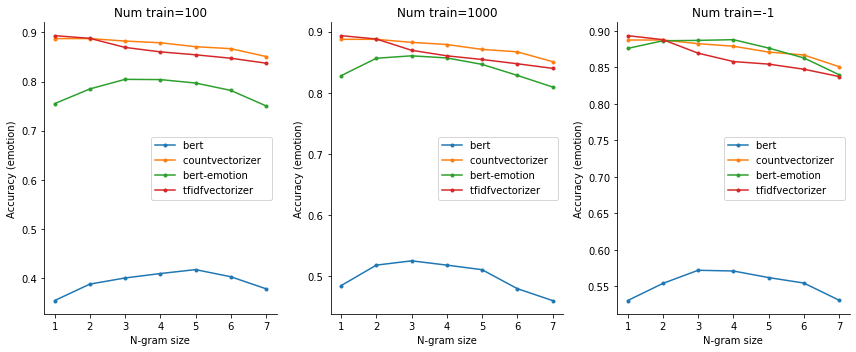

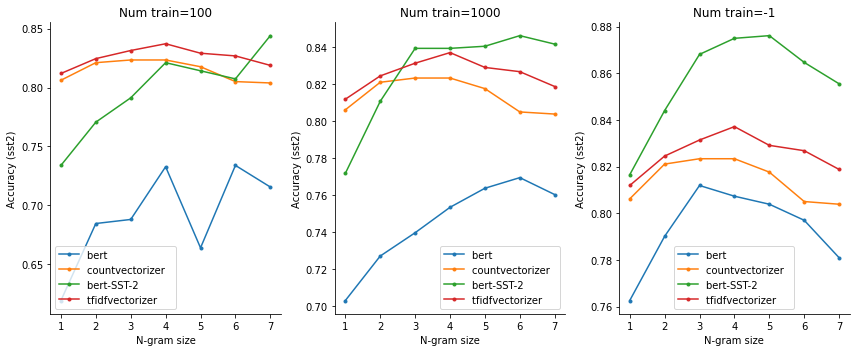

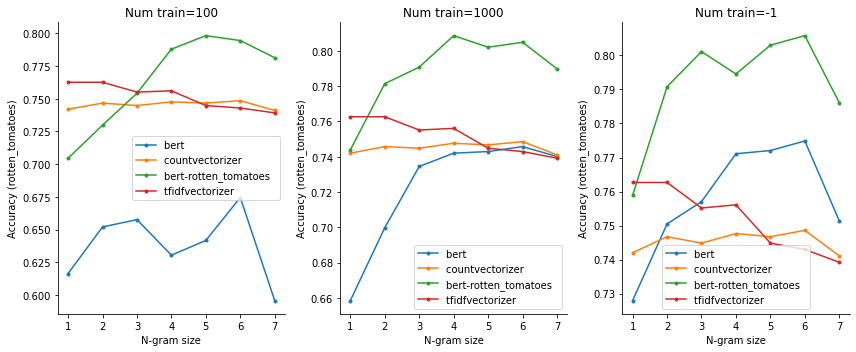

In [43]:
for dset in rs.dataset.unique():
    r = rs[rs.dataset == dset]

    R = 1
    C = 3
    plt.figure(figsize=(12, 5))
    # plt.figure(figsize=(8, 12))
    for i, subsample in enumerate([100, 1000, -1]):
        plt.subplot(R, C, i + 1)
        plt.title('Num train=' + str(subsample))
        d = r[r.subsample == subsample]

        curve = d.groupby(['checkpoint', 'all', 'norm'])
        for key, group in curve:
            g = group.sort_values('ngrams')
            plt.plot(g.ngrams, g.acc_val, '.-',
                     label=(
                         ' '.join(key)
                         .replace('textattack/', '')
                         .replace('bert-base-uncased', 'bert')
                         .replace('nateraw/', '')
#                          .lower()
                     ))
        plt.ylabel(f'Accuracy ({dset})')
        plt.xlabel('N-gram size')


        plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'results/acc_by_ngrams_{dset}.pdf')
    #     print(curve)

In [ ]:
##### (
r.sort_values(by=['subsample', 'acc_val'], ascending=False)
#     .fillna('')
#     .replace('', False)
# )